In [1]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate

This notebook is a description of a non-intrusive spectral method . This method is illustrated with by solving the stochastic elliptic equation

$$
\partial_x [ k(x,\theta) \partial_x u(x, k(\theta))] = f(x)
$$

for $x \in [0,1]$ and $\theta \sim $ log-normal$(\mu, \sigma)$.

A spectral method is any method used to calculate the coefficients $u_i$ and orthogonal basis $\psi_i$ of a spectral expansion. In this case, we want to find such elements for an expansion of $u(x,\theta)$. Something like:

$$
u(x, k(\theta)) = \sum_{s=1}^P u_s(x; k(\theta)) \psi_s(k(\theta))
$$

The problem here is that (for whatever reason) we can't take $\theta$ but instead we need to write the parameter $k$ as a combination of i.i.d. variables. This is where the germ comes into play. The germ is the vector $\underline{\xi} = (\xi_1, ..., \xi_{N_{kl}}) \in \mathbb{R}^{N_{kl}}$. We use then a truncated KL expansion over the random vector $\underline{\xi}$ to write an approximation of $k$,

$$\hat{k}^{(j)}(x, \underline{\xi}) = \mu + \sum_{i=1}^{N_{kl}} \sqrt{\lambda_i} \phi_i(x) \xi^{(j)}_i$$ for $j=1, .., M$ where $\xi^{(j)}_i$ is the $i$-th element of the $j$-th sample.

Therefore, the spectral expansion of the solution takes the form:

$$
u(x, \underline{\xi}) = \sum_{s=1}^P u_s(x,\underline{\xi} ) \psi_s(\underline{\xi})
$$
where by orthogonality, the coefficients $u_s(x,\underline{\xi} )$ are given by

$$
u_s(x,\underline{\xi} ) = \frac{1}{\|\psi_s\|^2} \int_\Xi u(x, \underline{\xi}) \psi_s(\underline{\xi}) dP(\xi) 
$$

These are the steps towards the non-intrusive spectral projection (NISP).

1. Generate M samples of $\underline{\xi}^{(j)}$ that are normal distributed. We choose this distribution because we it's a nice one; 

2. Compute the KL modes $\lambda_i$ and eigenvectors $\phi_i(x)$ of $\hat{k}$;

3. Compute the samples $\hat{k}^{(j)}$ using truncated KL-expansion;

4. Solve $M$ deterministic problems $\partial_x [ \hat{k}^{(j)} \partial_x u(x, k(\theta))] = f(x)$;

5. Generate $P$ Hermite polynomials of dimention $N_{kl}$ up to order N_0. These polynomials are Hermite because $\underline{\xi}$ are normal. This will be a vector that represent the  the polynomials of the basis at the samples sets, i.e., $[ ... \psi_i(\underline{\xi}^{(j)}), \psi_i(\underline{\xi}^{(j+1)}), ... ]$. Something exactly of the form (2.45) in <cite data-cite="5889918/R7EQDS7U"></cite>

6. Compute $u_s(x,\underline{\xi} )$ solving the integral with Monte-Carlo.

Generate M samples of $\underline{\xi}^{(j)}$ that are normal distributed. We choose this distribution because we it's a nice one;

In [37]:
Nkl = 7
M = 100


# 1.
mu = 1
sigma = 0.1

xi_samples = np.zeros((Nkl, M))
for i in range(Nkl):
    xi_samples[i, :] = np.random.normal(mu, sigma, M) 

Compute the KL modes $\sqrt{\lambda_i}$ and eigenvectors $\phi_i(x)$ of $\hat{k}$;

In [38]:
Nel = 12
Omega = np.linspace(0,1,Nel)
h = Omega[1] - Omega[0]
if Nel < Nkl:
    raise Exception('number of elements is smaller than the number of modes')
var = sigma**2
l = 0.1 

%run KL_decomposition.ipynb

Eign = KLexpansion(Nel, var, l)

#here we keeping the lardest Nkl modes corresponding eigenvectors 
modes = np.sqrt(Eign[0])[Nel - Nkl: Nel]
eigenvectors = Eign[1][Nel - Nkl: Nel,:] # eigenvectors[j,i] gives the eigenvector on point xi_j for mode i 

Compute the samples $\hat{k}^{(j)}$ using truncated KL-expansion;

In [39]:
k_samples = np.zeros( (M, Nel) ) # k(x, xi, j), j = 1,..., M

mu_vector = mu*np.ones(Nel)
for j in range(M):
    prod_aux = np.zeros( (Nkl,Nel) )
    for i in range(Nkl):
        prod_aux[i,:] = modes[i]*xi_samples[i,j]*eigenvectors[i,:]
    k_samples[j,:] = np.exp(mu_vector[:] + np.sum(prod_aux))

Solve $M$ deterministic problems $\partial_x [ \hat{k}^{(j)} \partial_x u(x, k(\theta))] = f(x)$;

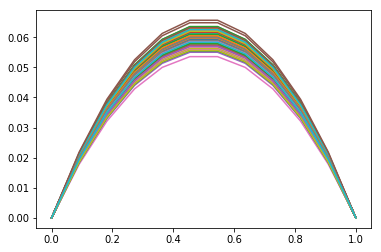

In [40]:
%run Galerkin1DElliptic.ipynb

f = lambda x: 1
alpha = Omega[0]  # LHS boundary
beta = Omega[-1]  # RHS boundary
u_alpha = 0       # u(0)
u_beta = 0        # u(1)

solution_samples = np.zeros((M,Nel))


for j in range(M):
    solution_samples[j,:] = Galerkin1DElliptic(Nel, f, alpha, beta, u_alpha, u_beta,\
                                               k_samples[j,:])
    plt.plot(Omega,solution_samples[j])

plt.show()

Generate $M$ samples of $N_{kl}$-dimensional polynomials up to order $N_0$.

In [41]:
%run Hermitepoly.ipynb

In [42]:
No = 3
P = int(math.factorial(No + Nkl)/(math.factorial(No)*math.factorial(Nkl))) - 1

gammaMatrix = np.zeros((P+1, M))

for i in range(M):
    gammaMatrix[:,i] = hermitepoly(xi_samples[:,i], No)

In [43]:
uCoeff = np.zeros((Nel, P+1))

norm_vector = np.zeros(P+1)
for p in range(P+1):
    s = 0
    for m in range(M):
        s += 1/M*gammaMatrix[p,m]**2
    norm_vector[p] = s 

print(norm_vector[76])

for s in range(P+1):
    integral = np.zeros(Nel)
    for m in range(M):
        integral[:] += gammaMatrix[s,m]*solution_samples[m,:]
    uCoeff[:,s] = 1/(M*norm_vector[s]**2)*integral

66.9138182907


In [44]:
sol = np.zeros(Nel)

for i in range(Nel): 
    for s in range(P+1):
        sol[i] += uCoeff[i,s]*gammaMatrix[s,1]

sol 

array([ 0.        ,  0.18024333,  0.324438  ,  0.432584  ,  0.50468133,
        0.54073   ,  0.54073   ,  0.50468133,  0.432584  ,  0.324438  ,
        0.18024333,  0.        ])

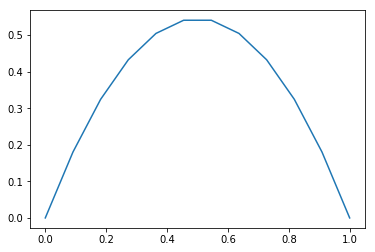

In [45]:
plt.plot(Omega,sol)
plt.show()